In [1]:
# mount the content of the folder called AIR_Project in google drive here

from google.colab import drive
drive.mount('/content/drive')

!ln -s "/content/drive/My Drive/AIR_Project" "/content/AIR_Project"


Mounted at /content/drive


In [2]:
import AIR_Project.dataset_preparation as dataset_preparation

Train dataset loaded successfully with 82022 records.
Val dataset loaded successfully with 5592 records.
Test dataset loaded successfully with 5593 records.


In [3]:
# Load the datasets
df_val_data = dataset_preparation.get_val_dataset()
df_test_data = dataset_preparation.get_test_dataset()

In [4]:
!pip install --quiet  tqdm     #for progress bars
!pip install --quiet transformers # for t5 model
!pip install --quiet tokenizers  #tokenizers from HuggingFace
!pip install --quiet sentencepiece #subword tokenizer used by T5
!pip install --quiet pytorch-lightning # pytorch wrapper
!pip install --quiet torchtext # text utilities
!pip install --quiet evaluate==0.4.3
!pip install --quiet -U bert_score
!pip install --quiet -U rouge_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━

In [5]:
import evaluate
from transformers import pipeline
from bert_score import plot_example
import matplotlib.pyplot as plt
import statistics
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from pprint import pprint
import copy
from transformers import (
    PegasusForConditionalGeneration,
    PegasusTokenizer
)

In [6]:
device  = 'cuda' if torch.cuda.is_available() else "cpu"

In [7]:
tokenizer = PegasusTokenizer.from_pretrained('alireza7/TRANSFORMER-persian-base-PN-summary',model_max_length=512)
model = PegasusForConditionalGeneration.from_pretrained('alireza7/TRANSFORMER-persian-base-PN-summary')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/2.24M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

In [8]:
class TextSummarizationDataset(Dataset):
    def __init__(self, tokenizer, split='train', max_len_inp=512,max_len_out=96):
        self.split = split

        self.article_column = "article"
        self.summary_column = "summary"

        if self.split == 'train':
          self.data = df_train_data
        elif self.split == 'val':
          self.data = df_val_data
        elif self.split == 'test':
          self.data = df_test_data

        print(self.data)

        self.max_len_input = max_len_inp
        self.max_len_output = max_len_out
        self.tokenizer = tokenizer
        self.inputs = []
        self.targets = []
        self._build()

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        source_ids = self.inputs[index]["input_ids"].squeeze()
        target_ids = self.targets[index]["input_ids"].squeeze()

        src_mask = self.inputs[index]["attention_mask"].squeeze()  #squeeze to get rid of the batch dimension
        target_mask = self.targets[index]["attention_mask"].squeeze()  # convert [batch,dim] to [dim]

        labels = copy.deepcopy(target_ids)
        labels [labels==0] = -100

        return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask,"labels":labels}

    def _build(self):
        for rownum,val in tqdm(self.data.iterrows()): # Iterating over the dataframe
            article,summary = val[self.article_column],val[self.summary_column]

            input_ = article # Input format for text summarization tasks
            target = summary # Output format we require

            # tokenize inputs
            tokenized_inputs = self.tokenizer.batch_encode_plus(
                [input_], max_length=self.max_len_input,padding='max_length',
                truncation = True,return_tensors="pt"
            )
            # tokenize targets
            tokenized_targets = self.tokenizer.batch_encode_plus(
                [target], max_length=self.max_len_output,padding='max_length',
                truncation = True,
                return_tensors="pt"
            )

            self.inputs.append(tokenized_inputs)
            self.targets.append(tokenized_targets)

In [9]:
val_dataset = TextSummarizationDataset(tokenizer, 'val')
test_dataset = TextSummarizationDataset(tokenizer, 'test')

                                                article  \
1     مدیر بازرگانی شرکت ملی پخش فرآورده‌های نفتی، د...   
2     به گزارش ایمنا به نقل از آناتولی، وزارت دفاع ت...   
3     سعید توکلی، مدیرعامل شرکت انتقال گاز به خبرنگا...   
4     افراد بسیار کمی هستند که می‌توانند ادعا کنند ا...   
5     به گزارش ایمنا به نقل از پایگاه خبری وزارت راه...   
...                                                 ...   
5588  عبدالحمید خدری در گفت‌وگو با خبرنگار شانا، با ...   
5589  مدیر شرکت ملی پخش فرآورده‌های نفتی منطقه تهران...   
5590  به گزارش روابط عمومی شرکت ملی گاز ایران، رئیس ...   
5591  به گزارش بازار و به نقل از روابط عمومی اداره ک...   
5592  به گزارش بازار، سعید موتمنی گفت: در پی کاهش قی...   

                                                summary  
1     شانا گروه پالایش و پخش: کارمزد چهار فرآورده نف...  
2     هواپیماهای ارتش ترکیه برای انتقال تیم‌های امدا...  
3     بهره برداری از خط ششم سراسری علاوه بر آنکه نقش...  
4     این جزیره که زمانی زندانی برای نگهداری از خطرن...  
5

5592it [00:16, 338.18it/s]


                                                article  \
1     مدیر شرکت ملی پخش فرآورده‌های نفتی منطقه سبزوا...   
2     به گزارش خبرگزاری مهر به نقل از معاونت علمی و ...   
3     به گزارش نشریه اویل اند گس، محمد سانوسی بارکین...   
4     فرهاد کاوه آهنگران در گفت‌وگو با خبرنگار ایمنا...   
5     در این حال، جو بایدن در یک رشته توییت خواستار ...   
...                                                 ...   
5589  به گزارش ایمنا پایگاه اطلاع رسانی گمرک ایران، ...   
5590  به گزارش روزنامه هندو از دهلی نو، شرکت هندوستا...   
5591  جمعی از نمایندگان مجلس شورای اسلامی در گفت‌وگو...   
5592  به گزارش سرویس ترجمه ایمنا، بسیاری از افراد در...   
5593  به گزارش شانا به نقل از روابط عمومی شرکت ملی پ...   

                                                summary  
1     مصرف نفت کوره منطقه سبزوار در بهار امسال، نسبت...  
2     رویدادی در آزمایشگاه نقشه برداری مغز در راستای...  
3     دبیرکل سازمان کشورهای صادرکننده نفت (اوپک) اعل...  
4     سخنگوی سازمان آتش نشانی اصفهان از حریق در کارگ...  
5

5593it [00:16, 333.87it/s]


In [10]:
model = model.to(device)

In [11]:
for i in range(10):
    item = val_dataset[i]

    article = tokenizer.decode(item['source_ids'], skip_special_tokens=True,clean_up_tokenization_spaces=True)
    summary = tokenizer.decode(item['target_ids'], skip_special_tokens=True,clean_up_tokenization_spaces=True)

    encoding = tokenizer.encode_plus(article,max_length =512,padding='max_length',
                                 truncation = True,
                                 return_tensors="pt").to(device)
    input_ids,attention_mask  = encoding["input_ids"].to(device), encoding["attention_mask"].to(device)

    model.eval()
    beam_outputs = model.generate(
      input_ids=input_ids,
      attention_mask=attention_mask,
      max_length=72, # How long the generated summmary should be
      early_stopping=True,
      num_beams=5,
      num_return_sequences=1
    )

    for beam_output in beam_outputs:
      predicted = tokenizer.decode(beam_output, skip_special_tokens=True,clean_up_tokenization_spaces=True)
      print(f"article : {article}")
      print(f'true summary : {summary}')
      print(f"predicted summary : {predicted}")
      print('-'*50)

article : مدیر بازرگانی شرکت ملی پخش فرآورده های نفتی، در گفتگو با شانا با بیان این که بر اساس مجوز یکشنبه (۱۸ اسفند ماه) شورای اقتصاد، کارمزد بنزین در جایگاههای عرضه فرآورده های نفتی کلانشهر تهران افزایش یافته است، افزود: این کارمزد با احتساب ۱۰۰ ریال کارمزد ویژه برای آن، ۳۵۰ ریال به ازای فروش هر لیتر بنزین تعیین شده است. [n] محمدرضا مظلومی تصریح کرد: در دیگر کلانشهرهای کشور نیز کارمزد این فرآورده نفتی (بنزین) با احتساب ۴۰ ریال کارمزد ویژه، ۲۹۰ ریال به ازای فروش هر لیتر بنزین در نظر گرفته شده است. [n] به گفته وی، کارمزد در دیگر جایگاههای عرضه فرآورده نیز به ازای هر لیتر فروش بنزین ۲۵۰ ریال است. [n] تا پیش از مصوبه شورای اقتصاد کارمزد فروش بنزین به ازای هر لیتر آن ۲۰۰ ریال محاسبه می شد. [n] مدیر بازرگانی شرکت ملی پخش فرآورده های نفتی با بیان این که برای جلوگیری از هرگونه مشکل برای جایگاه داران، در ماههای اخیر ۲۰ درصد از کارمزد جایگاههای عرضه سوخت به صورت علی الحساب به آنها پرداخت شده است، تصریح کرد: کارمزد قطعی (بر اساس نرخهای جدید) از ابتدای سال ۱۳۹۲ محاسبه و پرداخت می شود. [n] مظلومی

In [12]:
articles = []
references = []
hypotheses = []

num = len(test_dataset)

for i in tqdm(range(num)):
    item = test_dataset[i]

    article = tokenizer.decode(item['source_ids'], skip_special_tokens=True,clean_up_tokenization_spaces=True)
    summary = tokenizer.decode(item['target_ids'], skip_special_tokens=True,clean_up_tokenization_spaces=True)

    articles.append(article)
    references.append(summary)

    encoding = tokenizer.encode_plus(article,max_length =512,padding='max_length',
                                 truncation = True,
                                 return_tensors="pt").to(device)
    input_ids,attention_mask  = encoding["input_ids"].to(device), encoding["attention_mask"].to(device)

    model.eval()
    beam_outputs = model.generate(
      input_ids=input_ids,
      attention_mask=attention_mask,
      max_length=72, # How long the generated summary should be
      early_stopping=True,
      num_beams=5,
      num_return_sequences=1
    )

    for beam_output in beam_outputs:
      predicted = tokenizer.decode(beam_output, skip_special_tokens=True,clean_up_tokenization_spaces=True)
      hypotheses.append(predicted)

100%|██████████| 5593/5593 [1:11:16<00:00,  1.31it/s]


In [13]:
rouge = evaluate.load('rouge')

In [14]:
results = rouge.compute(predictions=hypotheses, references=references, tokenizer=lambda x: x.split())

rouge1_score = results.get('rouge1', None)
print(f'rouge1_score : {rouge1_score}')

rouge2_score = results.get('rouge2', None)
print(f'rouge2_score : {rouge2_score}')

rougeL_score = results.get('rougeL', None)
print(f'rougeL_score : {rougeL_score}')

rougeLsum_score = results.get('rougeLsum', None)
print(f'rougeLsum_score : {rougeLsum_score}')

rouge1_score : 0.3326573017390485
rouge2_score : 0.16312973138307676
rougeL_score : 0.28453749034399733
rougeLsum_score : 0.28468628545654123


In [15]:
bertscore = evaluate.load("bertscore")

In [16]:
results = bertscore.compute(predictions=hypotheses, references=references, lang="fa")

F1 = results.get('f1', None)
P = results.get('precision', None)
R = results.get('recall', None)

print(f"Bert Score F1 score: {statistics.mean(F1):.3f}")
print(f"Bert Score Precision score: {statistics.mean(P):.3f}")
print(f"Bert Score Recall score: {statistics.mean(R):.3f}")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Bert Score F1 score: 0.741
Bert Score Precision score: 0.742
Bert Score Recall score: 0.740


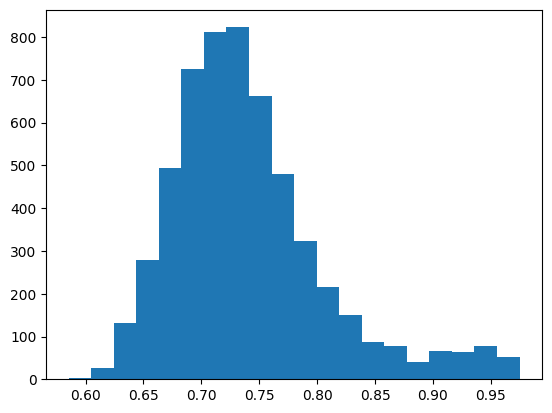

In [17]:
plt.hist(F1, bins=20)
plt.show()

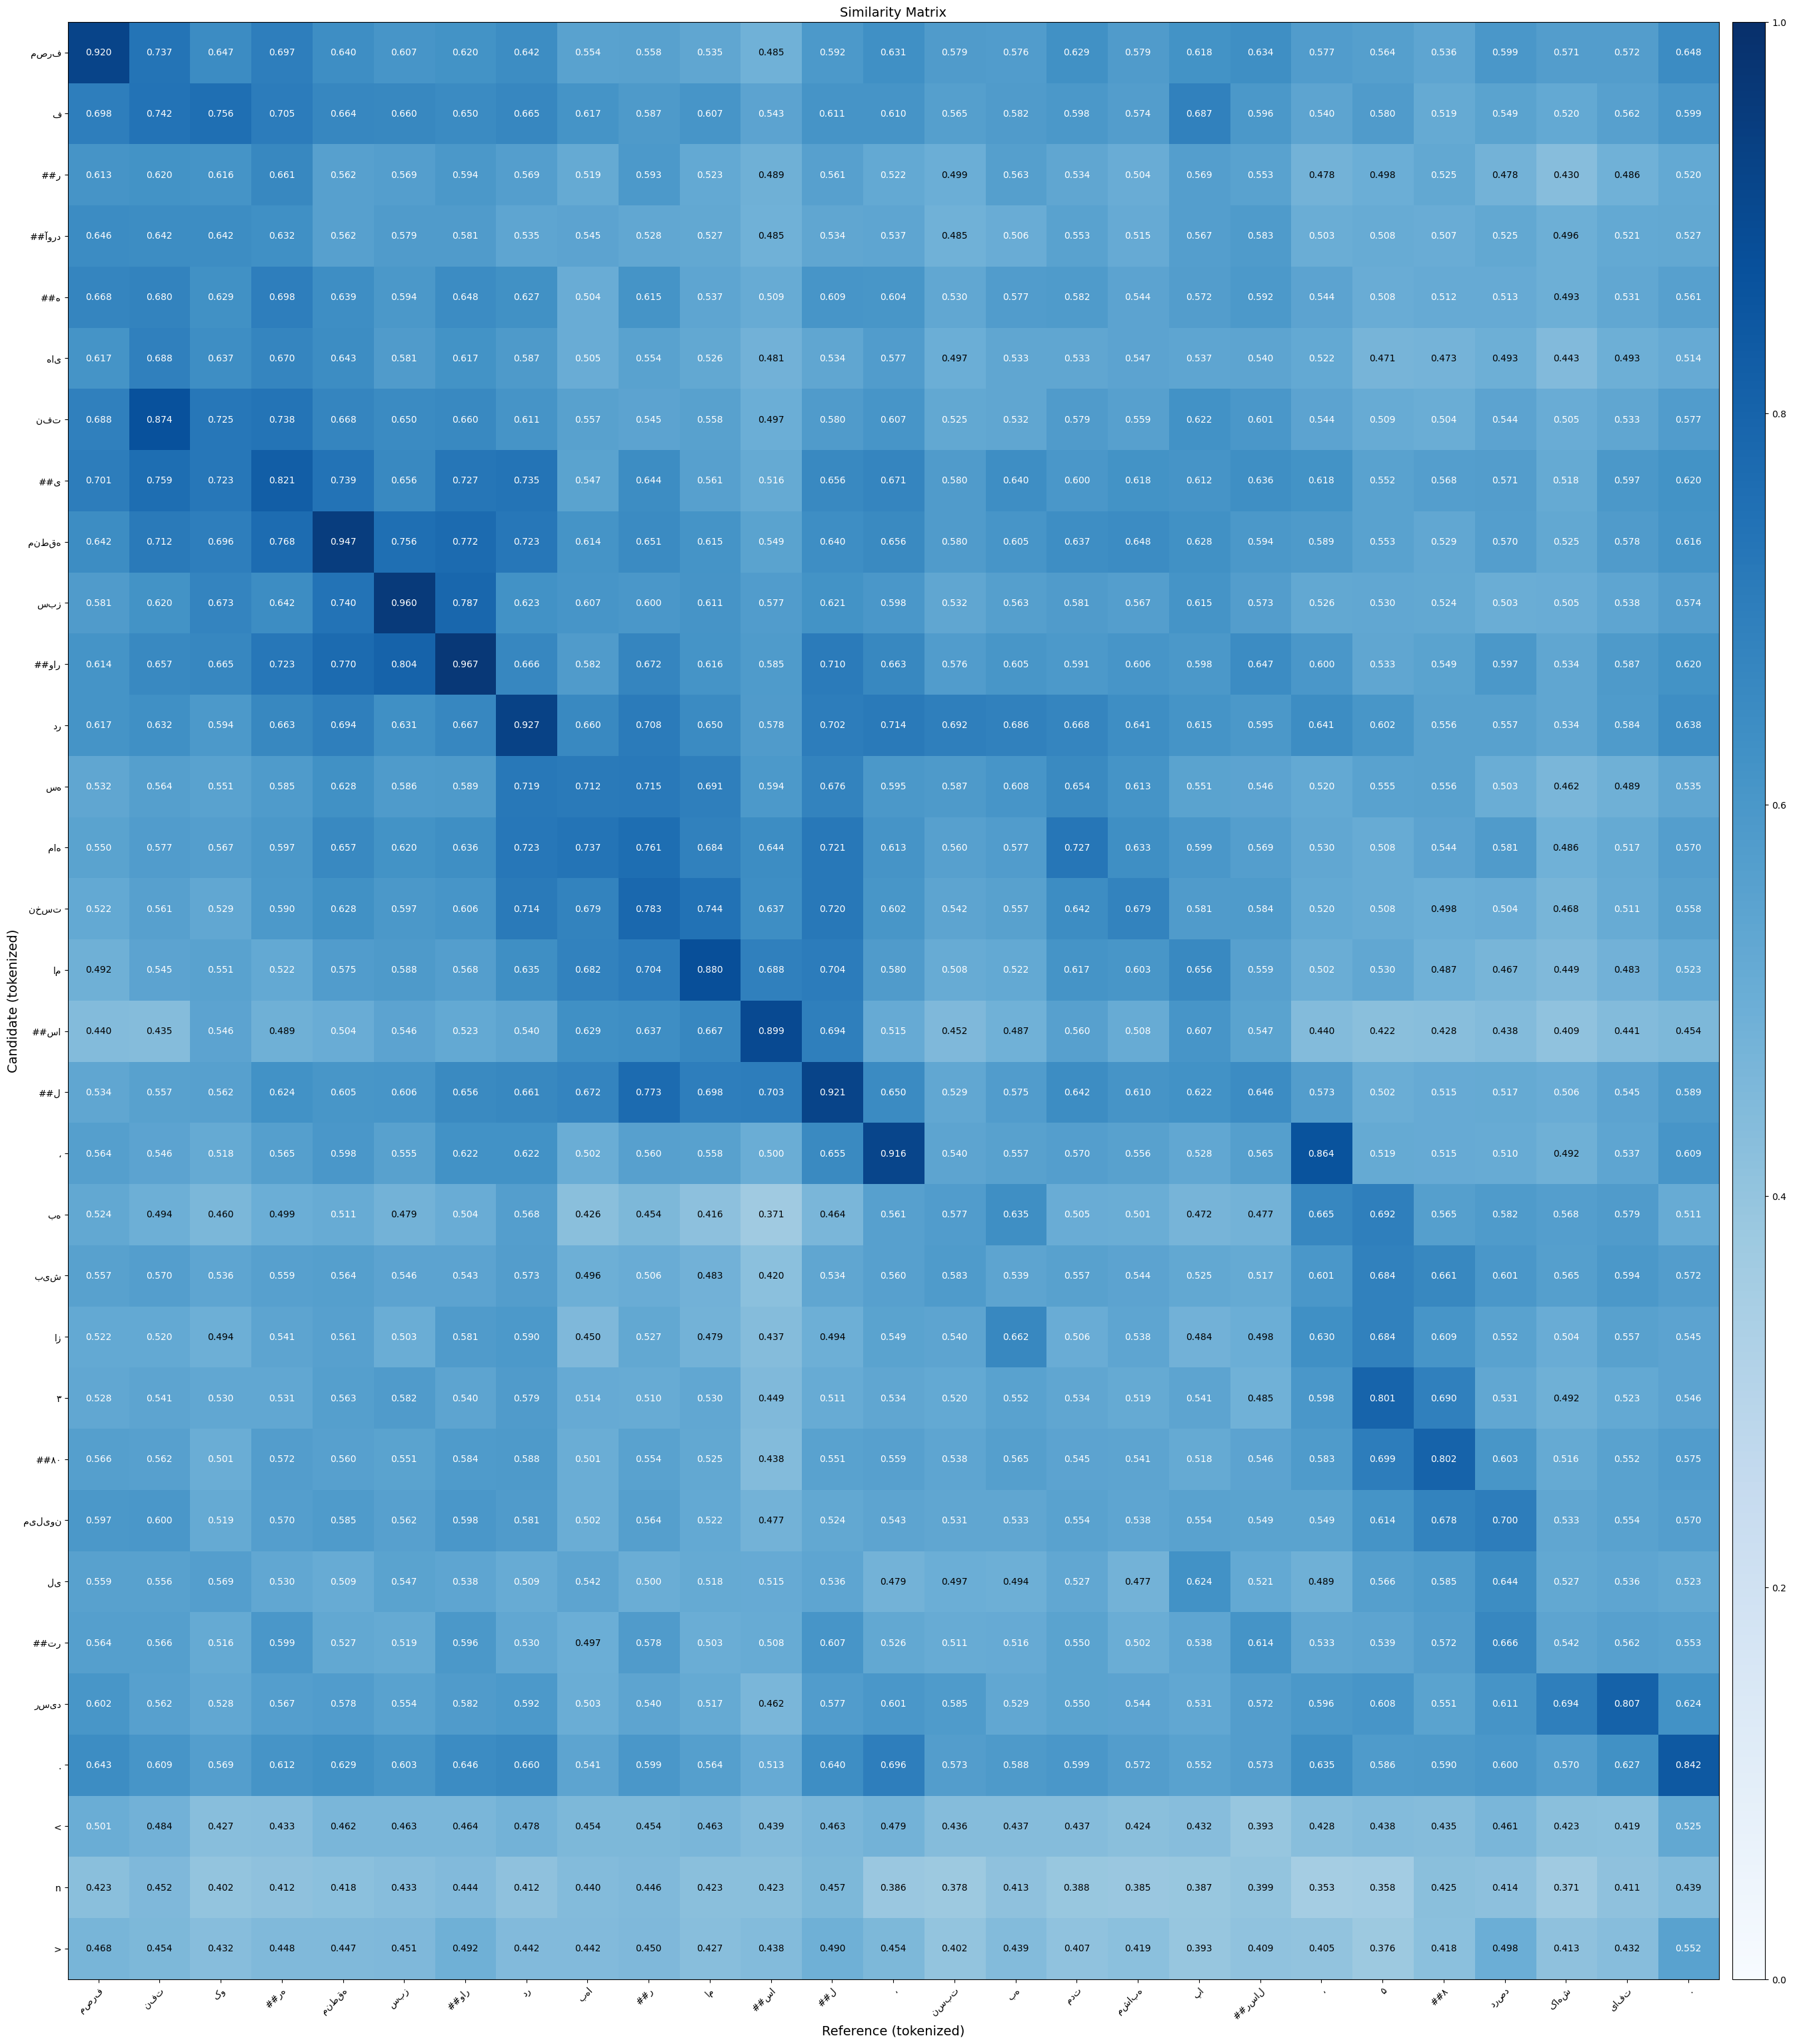

In [18]:
hypo = hypotheses[0]
ref = references[0]
plot_example(hypo, ref, lang="fa")

In [19]:
# Load the NER pipeline
ner_pipeline = pipeline("ner", model='HooshvareLab/bert-base-parsbert-ner-uncased')

config.json:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/651M [00:00<?, ?B/s]

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-ner-uncased were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


In [20]:
name_entity_references = []

for reference in references:
    entities = ner_pipeline(reference)
    words = []
    for entity in entities:
        word = entity['word']
        words.append(word)
    words_str = ' '.join(words)
    name_entity_references.append(words_str)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [21]:
name_entity_hypotheses = []

for hypothese in hypotheses:
    entities = ner_pipeline(hypothese)
    words = []
    for entity in entities:
        word = entity['word']
        words.append(word)
    words_str = ' '.join(words)
    name_entity_hypotheses.append(words_str)

In [22]:
for i in range(10):
  print(f'Reference name entities : {name_entity_references[i]}')
  print(f'hypothese name entities : {name_entity_hypotheses[i]}')
  print('-'*50)

Reference name entities : منطقه سبزوار بهار امسال پارسال ۵۸ درصد
hypothese name entities : منطقه سبزوار
--------------------------------------------------
Reference name entities : 
hypothese name entities : پژوهشکده زیست فناوری معاونت علمی و فناوری ریاست جمهوری پژوهشکده علوم اعصاب کره سال جاری
--------------------------------------------------
Reference name entities : سازمان کشورهای صادرکننده نفت اوپک
hypothese name entities : سازمان کشورهای صادرکننده نفت اوپک اوپک
--------------------------------------------------
Reference name entities : سازمان اتش نشانی اصفهان خیابان بهارستان غربی
hypothese name entities : سازمان اتش نشانی و خدمات ایمنی شهرداری اصفهان
--------------------------------------------------
Reference name entities : بی بی س ترامپ بایدن پنسیلوانیا جورجیا
hypothese name entities : دنیای اقتصاد ایالت پنسیلوانیا بایدن ۲۰۲۰ امریکا
--------------------------------------------------
Reference name entities : امورخارجه ایران کوبا
hypothese name entities : امورخارجه کشورمان ایر

In [23]:
results = bertscore.compute(predictions=name_entity_hypotheses, references=name_entity_references, lang="fa")

name_entity_F1 = results.get('f1', None)
name_entity_P = results.get('precision', None)
name_entity_R = results.get('recall', None)

print(f"name_entity_Bert Score F1 score: {statistics.mean(name_entity_F1):.3f}")
print(f"name_entity_Bert Score Precision score: {statistics.mean(name_entity_P):.3f}")
print(f"name_entity_Bert Score Recall score: {statistics.mean(name_entity_R):.3f}")

name_entity_Bert Score F1 score: 0.720
name_entity_Bert Score Precision score: 0.726
name_entity_Bert Score Recall score: 0.716
